# Tutorial: causal inference methods made easy for applied resarchers/epidemiologists/statisticians 

### ICON-LSHTM, LONDON, 16th October 2020

Miguel Angel Luque Fernandez PhD, Assistant Professor of Epidemiology and Biostatistics

Matthew Smith PhD, Research Fellow Inequalities in Cancer Outcomes Network, LSHTM, London, UK

Paul Zivich, University of North Carolina at Chapel Hill

Copyright (c) 2020 Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions: The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NON-INFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Bug reports: miguel-angel.luque at lshtm.ac.uk

The rhc dataset can be dowloaded at http://biostat.mc.vanderbilt.edu/wiki/Main/DataSets

In [1]:
%matplotlib inline

# Importing libraries for the tutorial
import patsy
import scipy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import zepid

from scipy.stats.kde import gaussian_kde
from scipy.stats import logistic
from zepid.calc import probability_to_odds, odds_to_probability

print("patsy      ", patsy.__version__)
print("scipy      ", scipy.__version__)
print("numpy      ", np.__version__)
print("pandas     ", pd.__version__)
print("statsmodels", sm.__version__)
print("matplotlib ", matplotlib.__version__)
print("zepid      ", zepid.__version__)

patsy       0.5.1
scipy       1.5.2
numpy       1.19.1
pandas      1.1.0
statsmodels 0.11.1
matplotlib  3.3.1
zepid       0.9.0


## Setting up the Data

In [2]:
# Box 1: Setting up the data
data = pd.read_csv("rhc.csv")
data.rename(columns={"rhc": "A", 
                     "death_d30": "Y",
                     "gender": "C",
                     "age": "W1",
                     "edu": "W2",
                     "race": "W3",
                     "carcinoma": "W4",
            }, inplace=True)
data['A'] = np.where(data['A'] == "Yes", 1, 0)
data['C'] = np.where(data['C'] == "Female", 0, 1)

data = data[["Y", "A", "C", "W1", "W2", "W3", "W4"]].copy()

## Naive estimate of the ATE

In [3]:
# Box 2: Regression naive approach
fm = smf.ols("Y ~ A + C", data).fit()
print(np.round(fm.params['A'], 5))  # ATE = 0.07352
fm.summary()  # Full model results

0.07352


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     16.59
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           6.58e-08
Time:                        06:30:58   Log-Likelihood:                -3812.9
No. Observations:                5735   AIC:                             7632.
Df Residuals:                    5732   BIC:                             7652.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3049      0.010     29.354      0.000       0.285       0.325
A              0.0735      0.013      5.739      0.000       0.048       0.099
C              0.0027      0.013      0.219      0.826      -0.022       0.027
==============================================================================
Omnibus:                    36985.427   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              993.118
Skew:                           0.696   Prob(JB):                    2.22e-216
Kurtosis:                       1.511   Cond. No.                         3.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
# Box 3: Marginal probabilities
pr_c1 = np.mean(data['C'])
pr_c0 = 1 - pr_c1
print("Prop. Male  ", np.round(pr_c1, 2))
print("Prop. Female", np.round(pr_c0, 2))

Prop. Male   0.56
Prop. Female 0.44


## 3. G-Formula

### 3.1 Non-parametric g-formula

In [5]:
# Box 4: Non-parametric g-formula for the ATE
pr_y_a1c1 = np.mean(data.loc[(data['C'] == 1) & (data['A'] == 1), 'Y'])
pr_y_a0c1 = np.mean(data.loc[(data['C'] == 1) & (data['A'] == 0), 'Y'])
pr_y_a1c0 = np.mean(data.loc[(data['C'] == 0) & (data['A'] == 1), 'Y'])
pr_y_a0c0 = np.mean(data.loc[(data['C'] == 0) & (data['A'] == 0), 'Y'])

ate = (pr_y_a1c1 - pr_y_a0c1)*pr_c1 + (pr_y_a1c0 - pr_y_a0c0)*pr_c0
print("ATE", np.round(ate, 6))

ATE 0.073692


In [6]:
# Box 5: Non-parametric g-formula for the ATT
pr_c1_a1 = np.mean(data.loc[data['A'] == 1, 'C'])
pr_c0_a1 = 1 - pr_c1_a1

att = (pr_y_a1c1 - pr_y_a0c1)*pr_c1_a1 + (pr_y_a1c0 - pr_y_a0c0)*pr_c0_a1
print("ATT", np.round(att, 6))

ATT 0.073248


In [7]:
# Box 6: Bootstrap the 95% confidence intervals (CI) for the
#        ATE/ATT estimated using the non-parametric G-Formula

def ate_nonparm_gformula(d):
    """Function to estimate the ATE using the nonparametric
    g-formula"""
    pr_c1 = np.mean(d['C'])
    pr_c0 = 1 - pr_c1

    pr_y_11 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 1), 'Y'])
    pr_y_01 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 0), 'Y'])
    pr_y_10 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 1), 'Y'])
    pr_y_00 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 0), 'Y'])
    
    return (pr_y_11 - pr_y_01)*pr_c1 + (pr_y_10 - pr_y_00)*pr_c0

## ATE ##
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    ate_rs.append(ate_nonparm_gformula(d=d_star))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal Approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))


def att_nonparm_gformula(d):
    """Function to estimate the ATT using the nonparametric
    g-formula"""
    pr_c1_a1 = np.mean(d.loc[data['A'] == 1, 'C'])
    pr_c0_a1 = 1 - pr_c1_a1

    pr_y_11 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 1), 'Y'])
    pr_y_01 = np.mean(d.loc[(d['C'] == 1) & (d['A'] == 0), 'Y'])
    pr_y_10 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 1), 'Y'])
    pr_y_00 = np.mean(d.loc[(d['C'] == 0) & (d['A'] == 0), 'Y'])
    
    return (pr_y_11 - pr_y_01)*pr_c1_a1 + (pr_y_10 - pr_y_00)*pr_c0_a1


## ATT ##
att_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    att_rs.append(att_nonparm_gformula(d=d_star))

print("\n95% Confidence limits for the ATT")
ci_perc = np.percentile(att_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
att_se = np.std(att_rs, ddof=1)
print("Normal Approx method:", np.round([att - 1.96*att_se,
                                          att + 1.96*att_se], 6))    

95% Confidence limits for the ATE
Percentile method:    [0.047741 0.099149]
Normal Approx method: [0.04798  0.099404]

95% Confidence limits for the ATT
Percentile method:    [0.048054 0.098375]
Normal Approx method: [0.047811 0.098686]


In [8]:
# Box 7: Non-parametric g-formula using saturated regression model (A)
data["A1"] = np.where(data['A'] == 1, 1, 0)
data["A0"] = np.where(data['A'] == 0, 1, 0)
fm = smf.ols("Y ~ A1 + A0 + A1:C + A0:C - 1", data).fit()
betas = fm.params
ate = np.mean((betas["A1"] + betas["A1:C"]*data["C"]) -
              (betas["A0"] + betas["A0:C"]*data["C"]))

print("ATE", np.round(ate, 6))

ATE 0.073692


In [9]:
# Box 8: G-formula with saturated regression model using zEpid
g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
g_formula.outcome_model("A + C + A:C",  # Estimating model
                        print_results=False)

g_formula.fit("all")  # all sets A=1
y_a1 = g_formula.marginal_outcome

g_formula.fit("none")  # none sets A=0
y_a0 = g_formula.marginal_outcome

print("ATE", np.round(y_a1 - y_a0, 6))

ATE 0.073692


### 3.2 Parametric g-formula

In [10]:
# Box 9: Parametric g-formula by hand
f = sm.families.family.Binomial()  # Using logit model unlike prev
fm_a1 = smf.glm("Y ~ C", data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C", data.loc[data["A"] == 0], family=f).fit()

y_a1 = fm_a1.predict(data['C'])
y_a0 = fm_a0.predict(data['C'])
ate = np.mean(y_a1 - y_a0)

print("ATE", np.round(ate, 6))

ATE 0.073692


In [11]:
# Box 10: Parametric Regression Adjustment
f = sm.families.family.Binomial()
fm = smf.glm("Y ~ A + C", data, family=f).fit()

da1 = data.copy()
da1['A'] = 1
y_a1 = fm.predict(da1)

da0 = data.copy()
da0['A'] = 0
y_a0 = fm.predict(da0)
ate = np.mean(y_a1 - y_a0)

print("ATE", np.round(ate, 6))

ATE 0.073514


In [12]:
# Box 11: Bootstrap for the parametric regression adjustment
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm = smf.glm("Y ~ A + C", d_star, family=f).fit()
    da = d_star.copy()
    da['A'] = 1
    y_a1 = fm.predict(da)
    da['A'] = 0
    y_a0 = fm.predict(da)
    ate_rs.append(np.mean(y_a1 - y_a0))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.048036 0.100379]
Normal approx method: [0.047652 0.099376]


In [13]:
# Box 12: Parametric multivariate regression adjustment implementation
f = sm.families.family.Binomial()
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()

y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)
ate = np.mean(y_a1 - y_a0)

print("ATE", np.round(ate, 6))

ATE 0.083929


In [14]:
# Box 13: Multivariate regression with zEpid
g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
g_formula.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                        "A:C + A:W1 + A:W2 + A:W3 + A:W4",
                        print_results=False)

g_formula.fit("all")  # all sets A=1
y_a1 = g_formula.marginal_outcome

g_formula.fit("none")  # none sets A=0
y_a0 = g_formula.marginal_outcome

print("ATE", np.round(y_a1 - y_a0, 6))

ATE 0.083929


In [15]:
# Box 14: Not Available for Python
# zEpid does not support two version of the parametric g-formula

In [16]:
# Box 15: Bootstrap for multivariate adjustment
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 1], 
                    family=f).fit()
    fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 0], 
                    family=f).fit()
    ate_rs.append(np.mean(fm_a1.predict(data) - fm_a0.predict(data)))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.059649 0.106662]
Normal approx method: [0.058851 0.109006]


In [17]:
# Box 16: Computing the parametric marginal risk ratio
f = sm.families.family.Binomial()
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()

y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)
risk_ratio = np.mean(y_a1) / np.mean(y_a0)

print("RR", np.round(risk_ratio, 4))

RR 1.2766


## 4. Inverse Probability of Treatment Weighting

### 4.1 Inverse probability of treatment weighting based on the propensity score plus regression adjustment

In [18]:
# Box 17: Computation of the IPTW estimator for the ATE
f = sm.families.family.Binomial()
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)  # Calculating propensity scores
data['p_score'] = p_score

iptw = 1 / np.where(data['A'] == 1, p_score, 1 - p_score)  # IPTW
data['iptw'] = iptw

d_a1 = data.loc[data["A"] == 1].copy()
d_a0 = data.loc[data["A"] == 0].copy()
ate = (np.average(d_a1['Y'], weights=d_a1['iptw']) - 
       np.average(d_a0['Y'], weights=d_a0['iptw']))
print("ATE", np.round(ate, 6))

ATE 0.083294


In [19]:
# Box 18: Bootstrap computation for the IPTW estimator
ate_rs = []
for i in range(1000):  # Drawing 1000 bootstrapped samples
    d_star = data.sample(n=data.shape[0], # Same size as input data
                         replace=True)  # Draw with replacement
    fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                    d_star, family=f).fit()
    ps_score = fm_pa.predict(d_star)  # Calculating propensity scores
    d_star['iptw'] = 1 / np.where(d_star['A'] == 1, 
                                  ps_score, 1 - ps_score)    
    ds_a1 = d_star.loc[d_star["A"] == 1].copy()
    ds_a0 = d_star.loc[d_star["A"] == 0].copy()
    ate_rs.append(np.average(ds_a1['Y'], weights=ds_a1['iptw']) - 
                  np.average(ds_a0['Y'], weights=ds_a0['iptw']))

print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

95% Confidence limits for the ATE
Percentile method:    [0.057431 0.106584]
Normal approx method: [0.058198 0.10839 ]


In [20]:
# Box 19: IPTW estimator using zEpid
ipw = zepid.causal.ipw.IPTW(data, treatment="A", outcome="Y")
ipw.treatment_model("C + W1 + W2 + W3 + W4", 
                    stabilized=False,  # Set to True for stabilized
                    print_results=False)
ipw.marginal_structural_model("A")
ipw.fit()
print(ipw.risk_difference)

                 RD    SE(RD)    95%LCL    95%UCL
labels                                           
Intercept  0.303444  0.007712  0.288328  0.318559
A          0.083294  0.013046  0.057723  0.108864


  Confounder       Raw  Weighted
2          C  0.093144  0.000325
3         W1 -0.061352 -0.003754
4         W2  0.091364 -0.002439
0         W3  0.035606  0.002426
1         W4  0.071853  0.000404


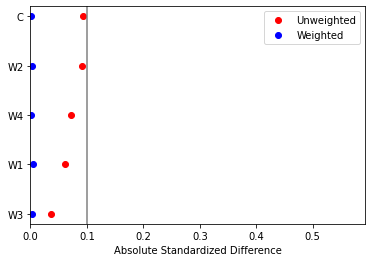

In [21]:
# Box 20: Assessing IPTW balance
rename_cols = {"smd_w": "Weighted", "smd_u": "Raw", 
               "labels": "Confounder"}

smd = ipw.standardized_mean_differences().rename(columns=rename_cols)
smd = smd.sort_values(by='Confounder')
print(smd[['Confounder', 'Raw', 'Weighted']])

# zEpid plotting functionality
ipw.plot_love()
plt.show()

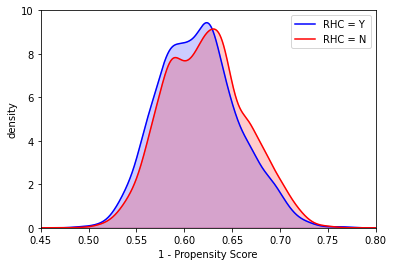

In [22]:
# Box 21: Assessing IPTW overlap by hand
density_t = gaussian_kde(1 - data.loc[data["A"] == 1, 'p_score'])
density_u = gaussian_kde(1 - data.loc[data["A"] == 0, 'p_score'])

x = np.linspace(0, 1, 10000)

ax = plt.gca()
ax.fill_between(x, density_t(x), color="b", alpha=0.2, label=None)
ax.plot(x, density_t(x), color="b", label='RHC = Y')
ax.fill_between(x, density_u(x), color="r", alpha=0.2, label=None)
ax.plot(x, density_u(x), color="r", label='RHC = N')
ax.set_ylim([0, 10])
ax.set_ylabel("density")
ax.set_xlim([0.45, 0.8])
ax.set_xlabel("1 - Propensity Score")
ax.legend()
plt.show()

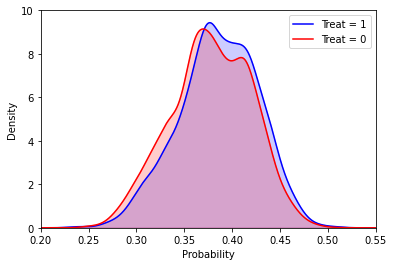

In [23]:
# Box 22: Assessing IPTW overlap using zEpid
ipw.plot_kde()
plt.ylim([0, 10])
plt.xlim([0.2, 0.55])
plt.show()

### 4.2 Marginal structural model with stabilised weights

In [24]:
# Box 23: Computation of the IPTW estimator using a MSM

### Unstabilized IPTW ###
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)  # Calculating propensity scores
iptw = 1 / np.where(data['A'] == 1, p_score, 1 - p_score)  # IPTW
# Estimating Marginal Structural Model
f = sm.families.family.Binomial(sm.families.links.identity())
fm = smf.gee("Y ~ A", data.index, data,
             cov_struct=sm.cov_struct.Independence(), 
             family=f, weights=iptw).fit()
print("Unstabilized Weights")
print("ATE   ", np.round(fm.params['A'], 6))
print("95% CL", np.asarray(fm.conf_int().loc["A"]))

### Stabilized IPTW ###
f = sm.families.family.Binomial()
# Numerator
fm_ma = smf.glm("A ~ 1", data, family=f).fit()
num = np.where(data['A'] == 1, fm_ma.predict(data), 
               1 - fm_ma.predict(data))
# Denominator
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
den = np.where(data['A'] == 1, fm_pa.predict(data), 
               1 - fm_pa.predict(data))
# IPTW
iptw = num / den
# Estimating Marginal Structural Model
f = sm.families.family.Binomial(sm.families.links.identity())
fm = smf.gee("Y ~ A", data.index, data,
             cov_struct=sm.cov_struct.Independence(), 
             family=f, weights=iptw).fit()
print("\nStabilized Weights")
print("ATE   ", np.round(fm.params['A'], 6))
print("95% CL", np.asarray(fm.conf_int().loc["A"]))

/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:501: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


Unstabilized Weights
ATE    0.083294
95% CL [0.05772325 0.10886425]


/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_estimating_equations.py:501: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)
/home/pzivich/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)



Stabilized Weights
ATE    0.083294
95% CL [0.05772325 0.10886425]


### 4.3 IPTW with regression adjustment

In [25]:
# Box 24: Computation of the IPTW-RA estimator
f = sm.families.family.Binomial()

fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1],  # Only A=1
                weights=data.loc[data["A"] == 1, 'iptw'], # Box 17
                family=f).fit()
y_a1 = fm_a1.predict(data)

fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0],  # Only A=0
                weights=data.loc[data["A"] == 0, 'iptw'],  # Box 17
                family=f).fit()
y_a0 = fm_a0.predict(data)

ate = np.mean(y_a1 - y_a0)
print("ATE", np.round(ate, 6))
ate = (np.mean(data['iptw']*data['A']*y_a1) / np.mean(data['iptw']*data['A']) - 
       np.mean(data['iptw']*(1-data['A'])*y_a0) / np.mean(data['iptw']*(1-data['A'])))
print("ATE", np.round(ate, 6))

ATE 0.083929
ATE 0.083426


In [26]:
# Box 25: IPTW-RA 
# Not supported by zEpid

## 5. Augmented Inverse Probability Weighting

In [27]:
# Box 26: Computation of the AIPTW estimator
f = sm.families.family.Binomial()

# Step 1: g-computation
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()
y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)

# Step 2: propensity scores
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)

# Step 3: analytic formula
ys_a1 = ((data['A'] * data['Y'])/ (p_score) + 
         (y_a1*(p_score-data['A'])) / p_score)
ys_a0 = (((1-data['A']) * data['Y'])/ (1-p_score) + 
         (y_a0*(data['A']-p_score)) / (1-p_score))
ate = np.mean(ys_a1 - ys_a0)
print("ATE", np.round(ate, 6))

# Step 4: bootstrap for inference
ate_rs = []
for i in range(1000):
    d_star = data.sample(n=data.shape[0], # Same size as input data
                     replace=True)  # Draw with replacement
    fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 1], family=f).fit()
    fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                    d_star.loc[d_star["A"] == 0], family=f).fit()
    y_a1 = fm_a1.predict(d_star)
    y_a0 = fm_a0.predict(d_star)
    fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                    d_star, family=f).fit()
    p_score = fm_pa.predict(d_star)
    ys_a1 = ((d_star['A'] * d_star['Y'])/ (p_score) + 
             (y_a1*(p_score-d_star['A'])) / p_score)
    ys_a0 = (((1-d_star['A']) * d_star['Y'])/ (1-p_score) + 
             (y_a0*(d_star['A']-p_score)) / (1-p_score))
    ate_rs.append(np.mean(ys_a1 - ys_a0))


print("95% Confidence limits for the ATE")
ci_perc = np.percentile(ate_rs, q=[2.5, 97.5])
print("Percentile method:   ", np.round(ci_perc, 6))
ate_se = np.std(ate_rs, ddof=1)
print("Normal approx method:", np.round([ate - 1.96*ate_se,
                                          ate + 1.96*ate_se], 6))

ATE 0.083796
95% Confidence limits for the ATE
Percentile method:    [0.058572 0.109738]
Normal approx method: [0.058901 0.108691]


In [28]:
# Box 27: AIPTW estimator with zEpid
aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
aipw.exposure_model("C + W1 + W2 + W3 + W4", 
                    print_results=False)
aipw.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                   "A:C + A:W1 + A:W2 + A:W3 + A:W4", 
                   print_results=False)
aipw.fit()

print("ATE   ", np.round(aipw.risk_difference, 6))
print("95% CL", np.round(aipw.risk_difference_ci, 6))
# zEpid calculates the variance using influence curves

ATE    0.083796
95% CL [0.058546 0.109046]


## 6. Data-Adaptive Estimation: Ensemble Learning Targeted Maximum Likelihood Estimation

In [29]:
# Box 28: Computation of TMLE by hand
f = sm.families.family.Binomial()
n = data.shape[0]

# Step 1: g-computation
fm_a1 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 1], family=f).fit()
fm_a0 = smf.glm("Y ~ C + W1 + W2 + W3 + W4", 
                data.loc[data["A"] == 0], family=f).fit()
y_a1 = fm_a1.predict(data)
y_a0 = fm_a0.predict(data)
y_a_ = np.where(data['A'] == 1, y_a1, y_a0)

# Step 2: propensity scores
fm_pa = smf.glm("A ~ C + W1 + W2 + W3 + W4", 
                data, family=f).fit()
p_score = fm_pa.predict(data)

# Step 3: targeting step
logodds_y1 = np.log(probability_to_odds(y_a1))
logodds_y0 = np.log(probability_to_odds(y_a0))
logodds_ya = np.log(probability_to_odds(y_a_))

clever_cov_a1 = data['A']/p_score
clever_cov_a0 = - (1-data['A'])/(1-p_score)

submodel = sm.GLM(data['Y'], 
                  np.column_stack((clever_cov_a1, clever_cov_a0)), 
                  offset=logodds_ya,
                  family=f).fit()
epsilon = submodel.params

# Step 4: calculating ATE
ys_a1 = logistic.cdf(logodds_y1 + epsilon[0] / p_score)
ys_a0 = logistic.cdf(logodds_y0 - epsilon[1] / (1-p_score))
ate = np.mean(ys_a1 - ys_a0)
print("ATE", np.round(ate, 6))

# Step 5: inference via influence curve
ic = (clever_cov_a1 + clever_cov_a0) * (data['Y'] - y_a_) + (y_a1 - y_a0) - ate
sd = np.sqrt(np.nanvar(ic, ddof=1) / n)
cl = [ate - 1.96*sd, ate + 1.96*sd]
print("95% CL", np.round(cl, 6))

ATE 0.083796
95% CL [0.058546 0.109047]


In [30]:
# Box 29: TMLE with zEpid
tmle = zepid.causal.doublyrobust.TMLE(data, 
                                      exposure="A", 
                                      outcome="Y")
tmle.exposure_model("C + W1 + W2 + W3 + W4", 
                    print_results=False)
tmle.outcome_model("A + C + W1 + W2 + W3 + W4 + "
                   "A:C + A:W1 + A:W2 + A:W3 + A:W4", 
                   print_results=False)
tmle.fit()

print("ATE   ", np.round(tmle.risk_difference, 6))
print("95% CL", np.round(tmle.risk_difference_ci, 6))

ATE    0.083796
95% CL [0.058546 0.109047]


## 7. Simulation

In [31]:
def data_generator(n, true_ate=False):
    """Function to generate data consisting of `n` observations"""
    d = pd.DataFrame()
    # Confounders
    d['W1'] = np.round(np.random.uniform(low=1, high=5, size=n))
    d['W2'] = np.random.binomial(n=1, p=0.45, size=n)
    d['W3'] = np.round(np.random.uniform(low=0, high=1, size=n)
                       + 0.8*d['W1'] + 0.75*d['W2'])
    d['W3'] = np.where(d['W3'] > 4, 1, d['W3'])
    d['W4'] = np.round(np.random.uniform(low=0, high=1, size=n)
                       + 0.2*d['W1'] + 0.75*d['W2'])
    # Treatment
    pr_a = logistic.cdf(-1 - 0.15*d['W4'] + 1.5*d['W2'] + 
                        0.75*d['W3'] + 0.25*d['W1'] + 
                        0.8*d['W2']*d['W4'])
    d['A'] = np.random.binomial(n=1, 
                                p=pr_a, 
                                size=n)
    # Potential outcomes
    pr_y1 = logistic.cdf(-3 + 1 + 0.25*d['W4'] + 0.75*d['W3'] + 
                         0.8*d['W2']*d['W4'] + 0.05*d['W1'])
    y1 = np.random.binomial(n=1, p=pr_y1, size=n)
    pr_y0 = logistic.cdf(-3 + 0 + 0.25*d['W4'] + 0.75*d['W3'] + 
                         0.8*d['W2']*d['W4'] + 0.05*d['W1'])
    y0 = np.random.binomial(n=1, p=pr_y0, size=n)
    # Causal consistency
    d['Y'] = np.where(d['A'] == 1, y1, y0)
    # Return generated data
    if true_ate:
        return np.mean(y1 - y0), np.mean(y1) / np.mean(y0)
    else:
        return d


# Generating true value from super-population
true_ate, true_rr = data_generator(n=1000000, true_ate=True)

# Setting up SuperLearner libraries
from zepid.superlearner import SuperLearner, StepwiseSL
from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM, f, s

import warnings
warnings.simplefilter('ignore', RuntimeWarning)  # Hides some NumPy errors for sparse models

family = sm.families.family.Binomial()

sl_library_main = [LogisticRegression(penalty='none', solver='lbfgs'),
                  StepwiseSL(family, selection="backward"), 
                  StepwiseSL(family, selection="forward", order_interaction=1)]
sl_main_labs = ["LogR", "Step.zero", "Step.one"]
sl_main = SuperLearner(sl_library_main, sl_main_labs, folds=5,
                       loss_function='nloglik')

sl_library_alt = [LogisticRegression(penalty='none', solver='lbfgs'),
                  StepwiseSL(family, selection="backward"), 
                  StepwiseSL(family, selection="forward", order_interaction=1),
                  LogisticGAM(f(0) + s(1) + f(2) + s(3) + s(4), 
                              lam=0.6)]
sl_alt_labs = ["LogR", "Step.zero", "Step.one", "GAM"]
sl_alt = SuperLearner(sl_library_alt, sl_alt_labs, folds=5,
                      loss_function='nloglik')

# Simulation
naive_rd, gform_rd, iptw_rd, aipw_rd, tmle_rd = [], [], [], [], []
aipw_slm_rd, aipw_sla_rd, tmle_slm_rd, tmle_sla_rd = [], [], [], []

for i in range(1000):    
    data = data_generator(n=1000)

    # Naive
    fm = smf.ols("Y ~ A + W1 + W2 + W3 + W4", data).fit()
    naive_rd.append(fm.params['A'])
    
    # G-formula
    g_formula = zepid.causal.gformula.TimeFixedGFormula(data, 
                                                    exposure="A", 
                                                    outcome="Y")
    g_formula.outcome_model("A + W1 + W2 + W3 + W4",
                            print_results=False)
    g_formula.fit("all")  # all sets A=1
    y_a1 = g_formula.marginal_outcome
    g_formula.fit("none")  # none sets A=0
    y_a0 = g_formula.marginal_outcome
    gform_rd.append(y_a1 - y_a0)
    
    # IPTW
    ipw = zepid.causal.ipw.IPTW(data, treatment="A", outcome="Y")
    ipw.treatment_model("W1 + W2 + W3 + W4", bound=0.01,
                        stabilized=True, print_results=False)
    ipw.marginal_structural_model("A")
    ipw.fit()
    iptw_rd.append(ipw.risk_difference)

    # AIPW
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                       print_results=False)
    aipw.fit()
    aipw_rd.append(aipw.risk_difference)
    
    # AIPW -- Super Learner main
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_main,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                        custom_model=sl_main,
                       print_results=False)
    aipw.fit()
    aipw_slm_rd.append(aipw.risk_difference)
    
    # AIPW -- Super Learner alternative
    aipw = zepid.causal.doublyrobust.AIPTW(data, 
                                       exposure="A", 
                                       outcome="Y")
    aipw.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_alt,
                        print_results=False)
    aipw.outcome_model("A + W1 + W2 + W3 + W4", 
                        custom_model=sl_alt,
                       print_results=False)
    aipw.fit()
    aipw_sla_rd.append(aipw.risk_difference)
    
    # TMLE
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       print_results=False)
    tmle.fit()
    tmle_rd.append(tmle.risk_difference)

    # TMLE -- Super Learner main
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_main,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       custom_model=sl_main,
                       print_results=False)
    tmle.fit()
    tmle_slm_rd.append(tmle.risk_difference)
    
    # TMLE -- Super Learner alternative
    tmle = zepid.causal.doublyrobust.TMLE(data, 
                                          exposure="A", 
                                          outcome="Y")
    tmle.exposure_model("W1 + W2 + W3 + W4", bound=0.01,
                        custom_model=sl_alt,
                        print_results=False)
    tmle.outcome_model("A + W1 + W2 + W3 + W4", 
                       custom_model=sl_alt,
                       print_results=False)
    tmle.fit()
    tmle_sla_rd.append(tmle.risk_difference)
    


In [32]:
# Results
result = [naive_rd, gform_rd, iptw_rd, aipw_rd, aipw_slm_rd, 
          aipw_sla_rd, tmle_rd, tmle_slm_rd, tmle_sla_rd]
labels = ["Naive", "G-formula", "IPTW", "AIPW", "AIPW-SL1", 
          "AIPW-SL2", "TMLE", "TMLE-SL1", "TMLE-SL2"]
for x, y in zip(result, labels):
    print("=============================")
    print(y)
    print("-----------------------------")
    print("Abs. Bias:", np.round(np.mean(x - true_ate), 3))
    rel_bias = np.abs(np.mean((x - true_ate) / true_ate)*100)
    print("Rel. Bias:", np.round(rel_bias, 1))
    print("=============================")


Naive
-----------------------------
Abs. Bias: 0.048
Rel. Bias: 26.7
G-formula
-----------------------------
Abs. Bias: 0.002
Rel. Bias: 0.8
IPTW
-----------------------------
Abs. Bias: 0.106
Rel. Bias: 58.5
AIPW
-----------------------------
Abs. Bias: 0.003
Rel. Bias: 1.9
AIPW-SL1
-----------------------------
Abs. Bias: 0.003
Rel. Bias: 1.5
AIPW-SL2
-----------------------------
Abs. Bias: 0.003
Rel. Bias: 1.7
TMLE
-----------------------------
Abs. Bias: 0.009
Rel. Bias: 4.8
TMLE-SL1
-----------------------------
Abs. Bias: 0.006
Rel. Bias: 3.5
TMLE-SL2
-----------------------------
Abs. Bias: 0.008
Rel. Bias: 4.5


END